## Import library

In [75]:
# !pip install imbalanced-learn

In [76]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score as r2, RocCurveDisplay
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score, roc_curve, precision_recall_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, StackingRegressor
from xgboost import XGBClassifier
from collections import Counter
import time
import datetime
import pytz

desired_timezone = pytz.timezone('Asia/Ho_Chi_Minh')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

## Define Variables

In [77]:
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [78]:
cols = ['avg_sent_time',
 'sent',
 'time_difference_mins',
 'avg_received_time',
 'total_txs',
 'avg_gas_fee',
 'unique_sent_addresses',
 'received',
 'unique_received_addresses', 'total_eth_received']

In [79]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/address_data_combined.csv"

## Load Data

In [80]:
df = pd.read_csv(data_path, usecols = cols + ['address', 'flag'])

In [81]:
df.head()

,address,avg_sent_time,avg_received_time,time_difference_mins,sent,received,unique_received_addresses,unique_sent_addresses,avg_gas_fee,total_txs,total_eth_received,flag
0,0x6c96769a08ddefa92e06de0a32089272c57f79b2,32.464093,0.0,173455.65,5343,0,0,3,0.006758,5343,0.0,1
1,0x73f858acd93866902f59a8b53ab5f8ae1824c74b,32.079906,0.0,173456.05,5407,0,0,3,0.006526,5407,0.0,1
2,0x8dab36ee57328e700380d1fd6588bc3de5fe8ec3,32.210966,0.0,173456.05,5385,0,0,3,0.006141,5385,0.0,1
3,0xc9c736bab11d24528c3543b14e610e5c6a30d921,57.475760,0.0,417906.25,7271,0,0,10,0.032492,7271,0.0,1
4,0xd74e2d68510786311f05a898ea6fa7a36727ee55,32.476325,0.0,173456.05,5341,0,0,3,0.006419,5341,0.0,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104788 entries, 0 to 104787
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   address                    104788 non-null  object 
 1   avg_sent_time              104788 non-null  float64
 2   avg_received_time          104788 non-null  float64
 3   time_difference_mins       104788 non-null  float64
 4   sent                       104788 non-null  int64  
 5   received                   104788 non-null  int64  
 6   unique_received_addresses  104788 non-null  int64  
 7   unique_sent_addresses      104788 non-null  int64  
 8   avg_gas_fee                104788 non-null  float64
 9   total_txs                  104788 non-null  int64  
 10  total_eth_received         104788 non-null  float64
 11  flag                       104788 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 9.6+ MB


In [83]:
X_sample = df.drop(columns=['address', 'flag'])
y_sample = df['flag']

In [84]:
# X_sample = X_sample.round(3)

## Resampling

In [85]:
counter = Counter(y_sample)
print(counter)

Counter({1: 94145, 0: 10643})


In [86]:
oversample = SMOTE(random_state=42)
X_resample, y_resample = oversample.fit_resample(X_sample, y_sample)

In [87]:
counter = Counter(y_resample)
print(counter)

Counter({1: 94145, 0: 94145})


## Training and Testing

### Split train and test data

In [88]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=42, stratify=y_resample)

In [89]:
counter = Counter(y_train_full)
print(counter)

Counter({1: 65902, 0: 65901})


In [90]:
scaler = MinMaxScaler()

In [91]:
# Log transformation for skewed data and scaling
for c in cols:
    # Log transformation
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling using only the training data to avoid data leakage
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [92]:
np.isnan(X_train_full_scaled).any()

False

In [93]:
X_train_full_scaled.shape

(131803, 10)

In [94]:
X_train_full.head()

,avg_sent_time,avg_received_time,time_difference_mins,sent,received,unique_received_addresses,unique_sent_addresses,avg_gas_fee,total_txs,total_eth_received
76630,9.023762,0.000000,10.815521,1.791759,0.000000,0.000000,1.098612,-5.939307,1.791759,0.000000
80150,6.565472,9.501068,12.881126,6.129050,1.609438,0.693147,3.850148,-4.974163,6.139885,5.447819
147118,11.724262,0.000000,12.417409,0.693147,0.000000,0.000000,0.693147,-5.736113,0.693147,0.000000
33192,10.399191,0.000000,11.092338,0.693147,0.000000,0.000000,0.693147,-7.417952,1.098612,-0.742097
117319,10.930019,10.582379,12.414507,1.098612,0.693147,0.000000,0.000000,-7.511289,1.609438,-0.905480


In [95]:
# X_train_full_scaled = np.round(X_train_full_scaled, 3)
# X_test_scaled = np.round(X_test_scaled, 3)

### Config model

In [96]:
xgb_params = {'learning_rate': 0.05,
              'max_depth': 8,
              'n_estimators': 1000}

### Functions

In [97]:
def get_model():
    xgb = XGBClassifier(**xgb_params)
    return xgb

In [98]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

In [99]:
def training_model(model, X, y):
    current_time = time.time()
    model.fit(X_train_full_scaled, y_train_full)
    training_time = time.time() - current_time

    current_time = time.time()
    y_pred = model.predict(X_test_scaled)
    prediction_time = time.time() - current_time

    return y_pred, training_time, prediction_time

### Training

In [100]:
xgb = get_model()

In [101]:
results= list()

scores = evaluate_model(xgb, X_train_full_scaled, y_train_full)
results.append(scores)

print('%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

0.994 (0.001)


In [102]:
results

[array([0.9939546 , 0.99454132, 0.9932107 , 0.99324144, 0.99295748])]

In [103]:
current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
df_sample = pd.DataFrame(results)
df_sample .to_csv(f"/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_evaluate_model_xgb.csv", index=False)

In [104]:
y_pred, training_time, prediction_time = training_model(xgb, X_train_full_scaled, y_train_full)

In [105]:
metrics_dict = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1': f1_score,
        'ROC-AUC': roc_auc_score
    }

xgb_metrics = {}
for metric, func in metrics_dict.items():
    xgb_metrics[metric] = func(y_test, y_pred)

### Result Model

In [106]:
sample = pd.DataFrame(y_pred, columns=['flag'])

In [107]:
sample

,flag
0,0
1,0
2,0
3,0
4,1
...,...
56482,1
56483,0
56484,1
56485,0


In [108]:
current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
sample .to_csv(f"/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_pred_model_xgb.csv", index=False)

In [109]:
xgb_metrics["training_time"]=training_time
xgb_metrics["prediction_time"]=prediction_time
sample = pd.DataFrame.from_dict(xgb_metrics, orient='index', columns=['Value'])


In [110]:
sample=sample.round(decimals=4)
sample

,Value
Accuracy,0.9942
Precision,0.9945
Recall,0.9940
F1,0.9942
ROC-AUC,0.9942
training_time,17.6657
prediction_time,2.2616


In [111]:
current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")

sample.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_xgb_model.csv', index=False)

### Plot

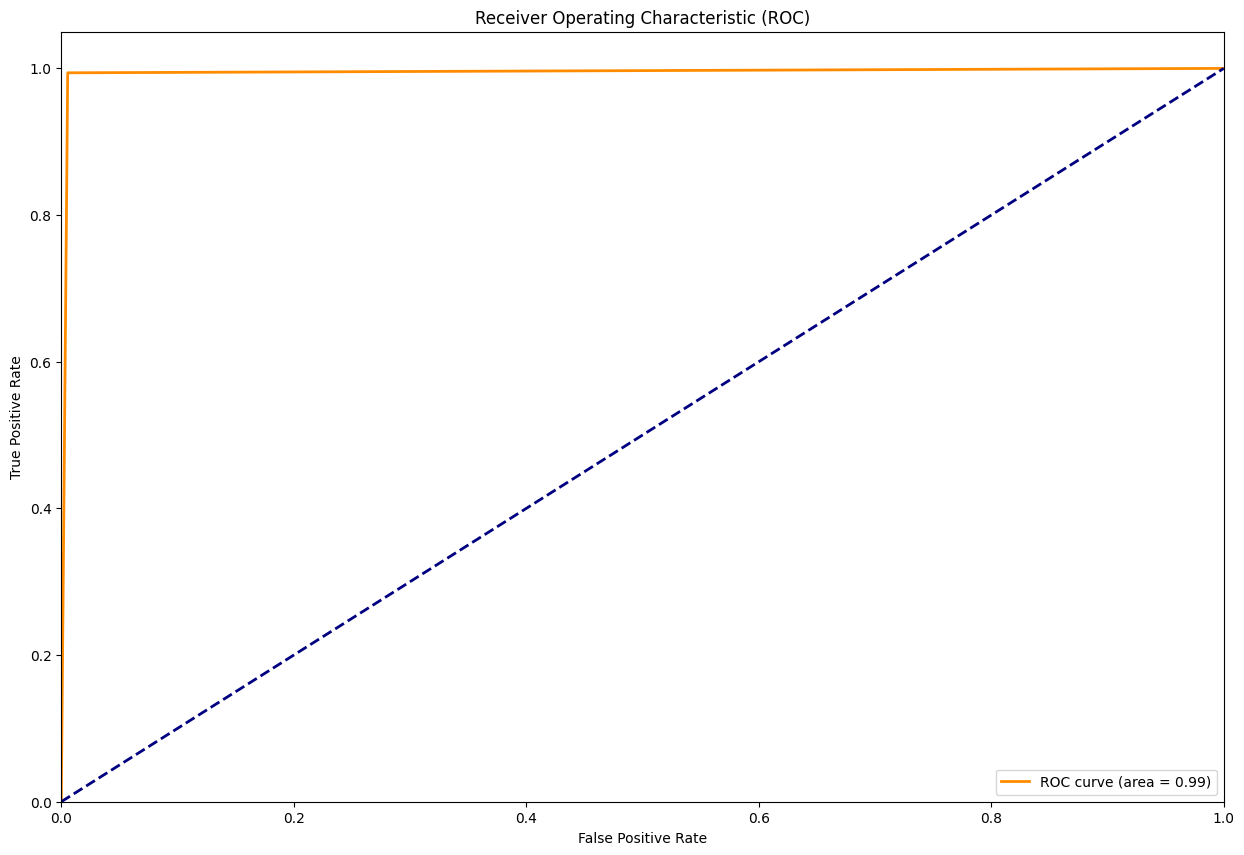

In [112]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_roc_xgb.png")

plt.show()

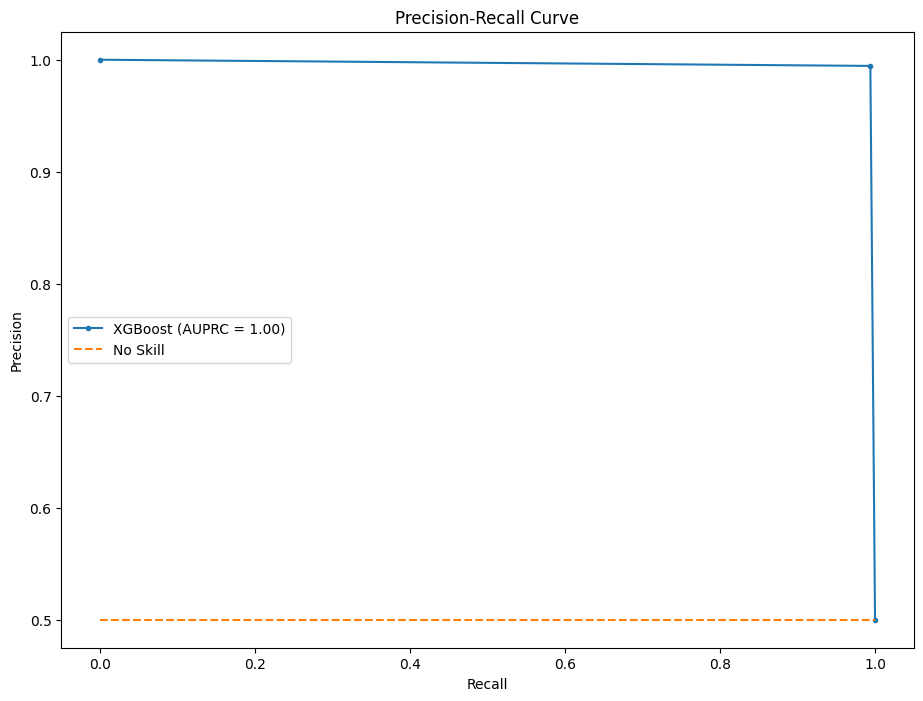

In [137]:
# Tính precision và recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Tính diện tích dưới đường cong PR
pr_auc = auc(recall, precision)

# Vẽ đường cong Precision-Recall
# plt.figure(figsize=(15, 9))
plt.plot(recall, precision,  marker='.', label=f'XGBoost (AUPRC = {pr_auc:.2f})')
no_skill = len(y_resample[y_resample==0]) / len(y_resample)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
# plt.grid(True)

# current = datetime.datetime.now()
# current_time_with_timezone = current.astimezone(desired_timezone)
# formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
# plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_pr_curve_xgb.png")
plt.show()

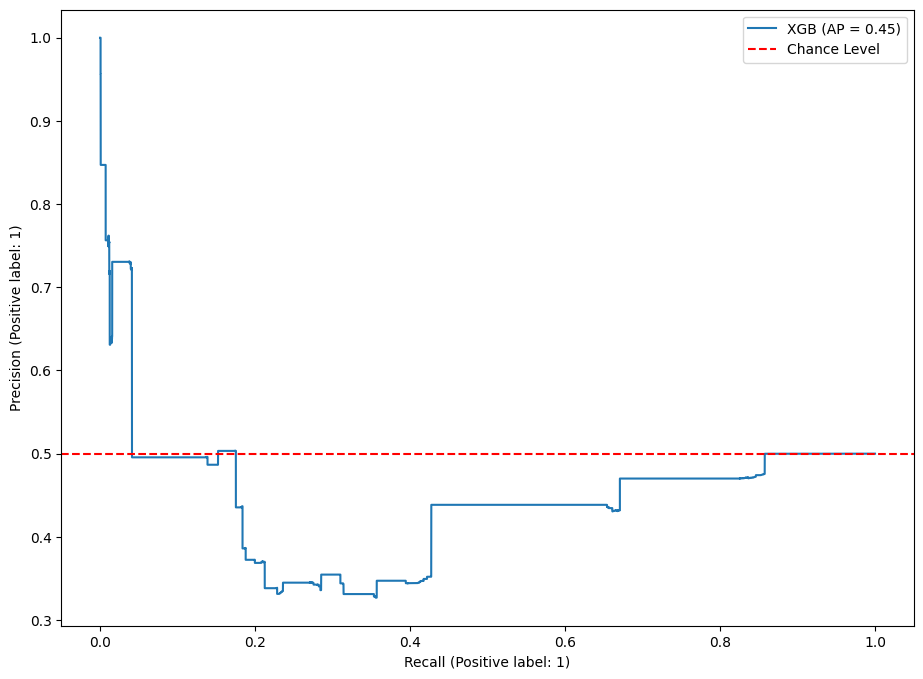

In [114]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgb, X_test, y_test, name="XGB"
)
# display.plot()

# Plot chance level
plt.axhline(y=np.mean(y_test), color='r', linestyle='--', label='Chance Level')
plt.legend()
plt.show()

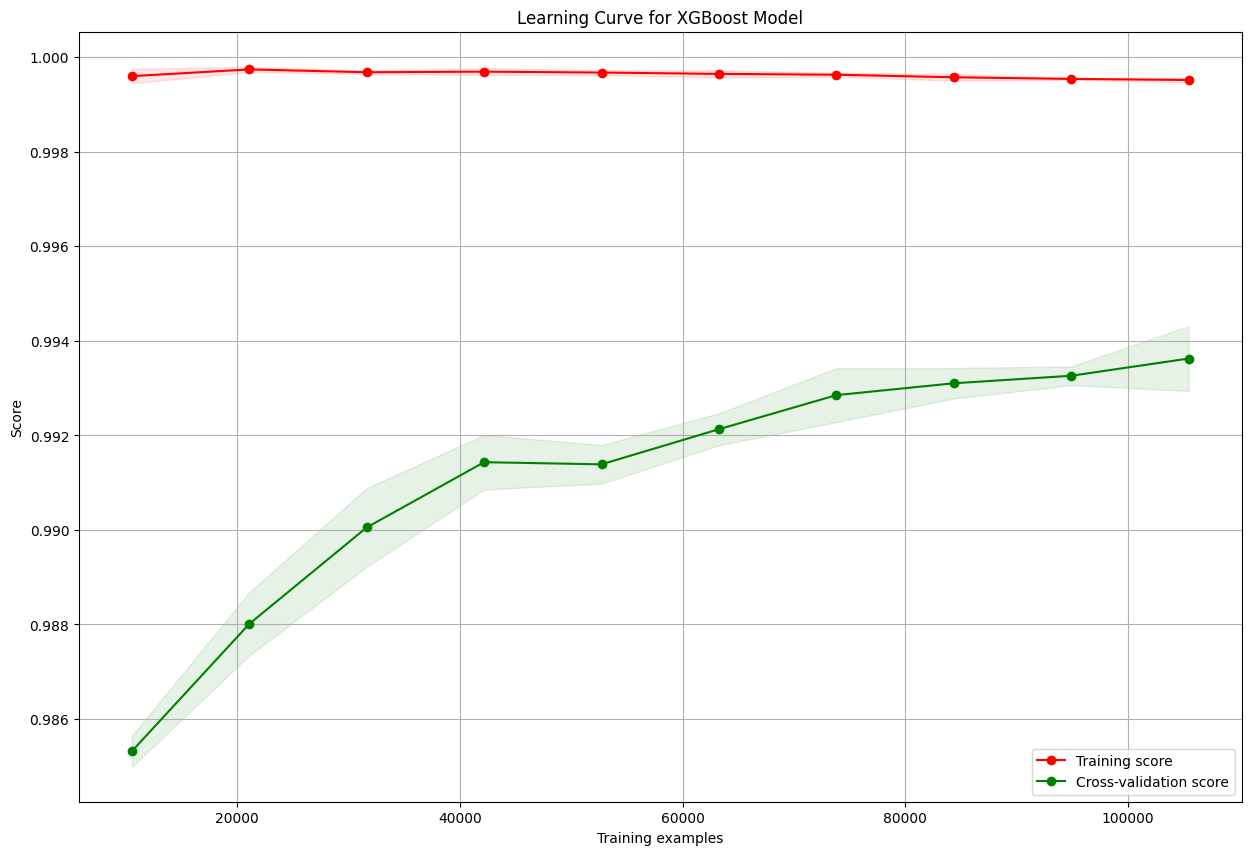

In [115]:
from sklearn.model_selection import learning_curve

# Tạo Learning Curve
train_sizes, train_scores, test_scores = learning_curve(xgb, X_train_full_scaled, y_train_full, cv=5, scoring='f1_macro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Tính trung bình và độ lệch chuẩn của các điểm số huấn luyện và kiểm tra
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)



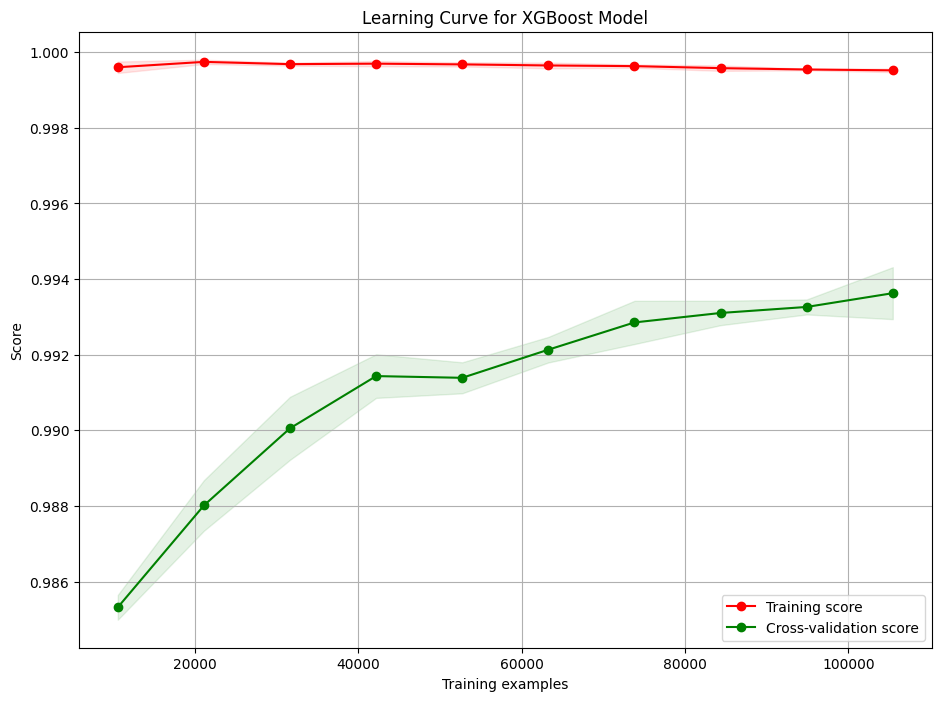

In [138]:
# Vẽ biểu đồ Learning Curve
# plt.figure(figsize=(15, 10))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve for XGBoost Model')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)

# current = datetime.datetime.now()
# current_time_with_timezone = current.astimezone(desired_timezone)
# formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
# plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/Dataset/XGB/{formatted_date}_learning_curve_xgb.png")

plt.show()